# The OLG model with population growth

# Model Description

We choose an OLG model, having the following attributes:
* Time is discrete and infinite
* Agents in the economy live for only 2 periods
* The population grows at a constant rate n
* Agents supply 1 unit of labor when young, splitting their wage between consumption and savings
* Agents do not work when old, and simply live off their gross savings
* Production is according to a well-behaved CD production function

Our model consists of the following equations:

$$L_{t+1} = L_{t}(1+n)$$
$$Y_t = AK_t^aL_t^{1-a}$$
$$U_t = u(c_{1t}) + \beta u(c_{2t+1})$$
$$u(c_t) = log(c_t)$$
$$K_{t+1} = S_t = s_tL_t$$
$$k_t = \frac{K_t}{L_t}$$

Budget constraints:
$$c_{1t} + s_t = w_t$$
$$c_{2t+1} = (1+r_{t+1})s_t$$

lifetime BC:
$$c_{1t} + \frac{c_{2t+1}}{1+r_{t+1} } = w_t $$


Parameter expression:
$$\beta = \frac{1}{1 + \rho}$$


Imports and set magics:

In [21]:
import numpy as np
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt
from IPython.display import display, Math

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject as ml

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model analysis

In the following section we will solve the model analytically primarely using sympy, it should be noted that the solution is for capital per capita denotdt be lower case k.
We do this by differentiation of the utility after substitution in the budget contraints and then isolating k with the knowlege of the relationship between s and k given by the model equations. 

In [31]:
#Solves the model analytically:
ml.OLG_analytical()

wage equation for w_t:


<IPython.core.display.Math object>

differentiated utility:


<IPython.core.display.Math object>

s_t:


<IPython.core.display.Math object>

s_t with w_t inserted:


<IPython.core.display.Math object>

steady state for capital per capita


<IPython.core.display.Math object>

steady state for capital per capita, numerically
[0.20364675706791072]


<function _lambdifygenerated(alpha, n, beta)>

Note that the steady state level of capital per capita is the same as usually found in the textbooks, the denominator has just bin written out and the exponent has been rewriten

From the analytical aproach of solving the model, we find that the steady state for k*, which is the value of capital where k in period t is equal to k in period t+1, is equal to around 0.2.

# Model simulation

We have used the optimize.root_scalar and bisect method, so to find the root of the euler error, as this should be zero. We have done this by finding the interval where the error changes sign, and used the corresponding s-values to create a bound that the optimal s should be in. the bisection method then bisects this interval to find a root

Now we solve the model using an optimiazation routine and then simulate it. Then we plot the development of capital as time goes towards the teadty state level found in the section above. We do so for different values of the parameters we have selected, to examinee the impact on the long run capital levels in the economy.

In [38]:
ml.first_results()

Consumption by old people in t=0: sim.C2[0] =  0.2504
Consumption by young people in t=0: sim.C1[0] =  0.2105
Consumption by old people in t=1: sim.C2[1] =  0.3126
Consumption by young people in t=1: sim.C1[1] =  0.2411
euler-error from period 0 to 1: -2.16153417
simulation done in 0.01 secs
euler error after model has been simulated 6.662004281565714e-12


## Changes to beta

simulation done in 0.02 secs
simulation done in 0.01 secs


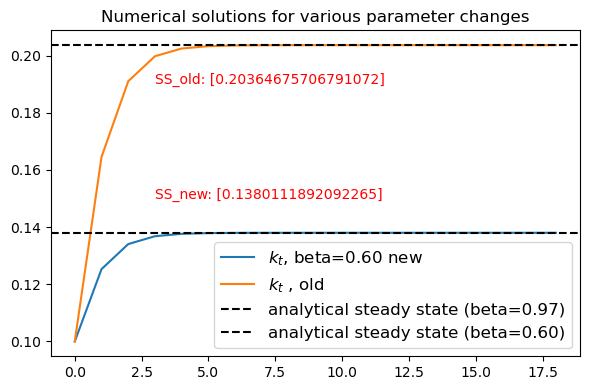

In [46]:
ml.model_beta06()

From the plot it is clear that the long run steady state levels fall as beta falls, where beta is an expression that is negatively affected by rho, which is the discounting rate cf. model equations. This is due to the fact that people care less about the future consumption and therefore consumes more today and save less for consumption tomorow, leading to less capital overall because it dosen't accumulate due to interet rates.  

## Changes to alpha (the weight of captail in the production function)

simulation done in 0.02 secs
simulation done in 0.02 secs


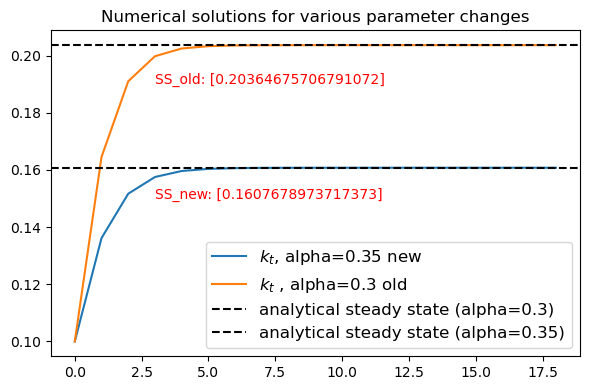

In [47]:
ml.model_alpha035()

From the plot we can see that the long run capital levels and thereby the steady state levels fall as alpha becomes larger, this is due to the fact that the productivity of capital rises such that less caitall is needed to maintain the same production levels. 

## Changes to n (the population growth)

simulation done in 0.01 secs
simulation done in 0.01 secs


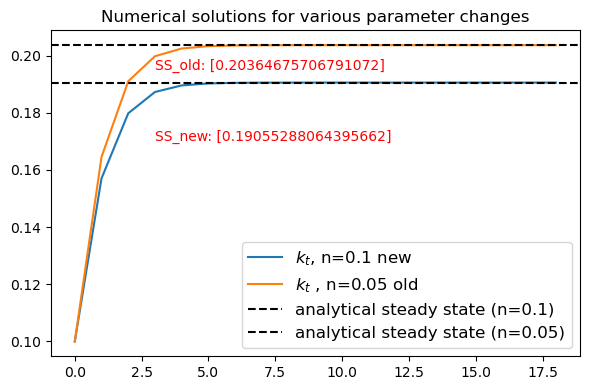

In [49]:
ml.model_n01()

As shown in the plot above, the steady state of capital per capita decreases when n increases. This makes intuitive sense and can also be seen in the analytical solution, as an increase in population growth means there are more people to distribute the capital on, resulting in capital per capita being lower.

We extend our model such that we introduce a goverment that raises contributions from the current young, invests them, and then pays benefits to the contributors, when they are old. This is also known as a fully funded OLG model. 

# Government implementation, Fully Funded system

simulation done in 0.01 secs
simulation done in 0.01 secs
savings_rate_old[18]: 0.49238578680291384
savings_rate_new[18]: 0.36548223350116776


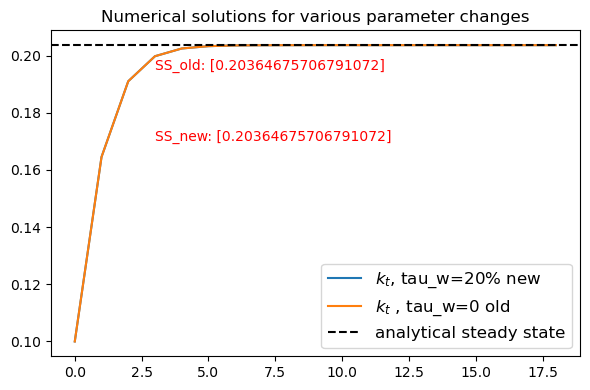

In [53]:
ml.taxes()

When introducing a government and a fully funded system, we find that the steady state capital level doesnt change. However the savings rate goes down corresponding to what the tax is, so the same amount is invested as before. The households simply adjust their savings to take the "forced savings" (the tax) into account when choosing how much of their wage to save.  Note again that the savings rate is the savings rate according to the disposable income. 

# Conclusion

We find that it is possible to use the numerical method of solving the model and get the same steady state as we do analytically (see figure 1). When increasing the population growth, the productivity of capital or decreasing the discount factor, the steady state level of capital per capita falls as expected both analytically and intuitively.

When introducing a government and a wage tax, we find that while the steady state capital per capita remains the same, the savings rate decreases as they take the tax as a pension they dont have to save themselves